# Imports

In [55]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

# Загрузка и подготовка данных

При загрузке датасета применим параметр `num_words` = 10 000

Слова ранжируются по тому, как часто они встречаются в обучающем наборе, 
и сохраняются только `num_words` наиболее часто встречающихся слов. 
Любое менее частое слово будет отображаться как значение oov_char в данных 
последовательности. Если None, все слова сохраняются. По умолчанию — None.

https://keras.io/api/datasets/imdb/

In [45]:
max_words=10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, seed=42)

Посмотрим что представляют собой загруженные данные

In [46]:
x_train[:5]

array([list([1, 11, 4079, 11, 4, 1986, 745, 3304, 299, 1206, 590, 3029, 1042, 37, 47, 27, 1269, 2, 7637, 19, 6, 3586, 15, 1367, 3196, 17, 1002, 723, 1768, 2887, 757, 46, 4, 232, 1131, 39, 107, 3589, 11, 4, 4539, 198, 24, 4, 1834, 133, 4, 107, 7, 98, 413, 8911, 5835, 11, 35, 781, 8, 169, 4, 2179, 5, 259, 334, 3773, 8, 4, 3497, 10, 10, 17, 16, 3381, 46, 34, 101, 612, 7, 84, 18, 49, 282, 167, 2, 7173, 122, 24, 1414, 8, 177, 4, 392, 531, 19, 259, 15, 934, 40, 507, 39, 2, 260, 77, 8, 162, 5097, 121, 4, 65, 304, 273, 13, 70, 1276, 2, 8, 15, 745, 3304, 5, 27, 322, 2197, 2, 2, 70, 30, 2, 88, 17, 6, 3029, 1042, 29, 100, 30, 4943, 50, 21, 18, 148, 15, 26, 5980, 12, 152, 157, 10, 10, 21, 19, 3196, 46, 50, 5, 4, 1636, 112, 828, 6, 1003, 4, 162, 5097, 2, 517, 6, 2, 7, 4, 9527, 5593, 4, 351, 232, 385, 125, 6, 1693, 39, 2383, 5, 29, 69, 5593, 5670, 6, 162, 5097, 1567, 232, 256, 34, 718, 5612, 2980, 8, 6, 226, 762, 7, 2, 7830, 5, 517, 2, 6, 3242, 7, 4, 351, 232, 37, 9, 1861, 8, 123, 3196, 2, 5612, 188

In [47]:
y_train[:5]

array([1, 0, 1, 0, 0])

x_train, x_test - это списки токенов. 
Каждому слову в исходных последовательностях (отзывах на фильмы) поставлено в соответствие 
некое число - токен. Именно последовательности этих чисел находятся в датасете.

С y_train, y_test все понятно - 1 означает, что отзыв положительный, 0 - отрицательный.

Но посмотрим на длины последовательностей x_train, x_test

In [48]:
for i in range(10): print(len(x_train[i]), end=' ')

467 138 147 168 144 248 125 204 138 182 

Видим, что отзывы отличаются по длине, что неудивительно.
Но на вход рекуррентной модели следует подавать последовательности одинаковой длины.
Поэтому перед использованием все входные последовательности и в обучающей 
и в тестовой выборках, следует привести к одинаковой длине.
Для этого будем использовать функцию `pad_sequences`

In [49]:
max_review_len = 200
x_train = pad_sequences(x_train, maxlen=max_review_len)
x_test = pad_sequences(x_test, maxlen=max_review_len)

In [51]:
x_train[:10]

array([[ 299,    4,  172, ...,    4,  392,  555],
       [   0,    0,    0, ...,  194,  194,  164],
       [   0,    0,    0, ...,    5,   55,  441],
       ...,
       [  13,  169,  108, ...,   19,   35,    2],
       [   0,    0,    0, ...,   20,  693,  158],
       [   0,    0,    0, ...,   14,   16, 1262]], dtype=int32)

Видим, что высказывания длиннее 200 слов обрезаны, а короткие дополнены нулями впереди.
Кроме того, от матрицы 25000 х 1 мы перешли к матрице 25000 х 200

# Создание нейронной сети

При построении моделей для работы с текстами, кроме предварительной токенизации,
также следует использовать специальный слой - 
## Embedding

`embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)`
Слой `Embedding` принимает как минимум два аргумента: 
количество возможных токенов и размерность пространства (в данном случае 256)

Слой `Embedding` лучше всего воспринимать как словарь, преобразующий целочисленные 
индексы (обозначающие конкретные слова) в плотные векторы. 
Он принимает целые числа на входе, отыскивает их во внутреннем словаре
и возвращает соответствующие векторы. Это операция поиска в словаре:

`Индекс слова -> слой Embedding -> Вектор, соответствующий слову`

Слой `Embedding` получает на входе двумерный тензор с целыми числами и формой 
(образцы, длина_последовательности), каждый элемент которого является
последовательностью целых чисел, и возвращает трехмерный тензор с вещественными 
числами и формой (образцы, длина_последовательности, размерность_векторного_представления).

Для построения сети будем использовать функциональный API

In [75]:
inputs = keras.Input(shape=(max_review_len, ))
embedded = layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_review_len)(inputs)
x = layers.LSTM(units=128, return_sequences=True)(embedded)
x = layers.LSTM(units=64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_10 (LSTM)              (None, 200, 128)          131584    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1461057 (5.57 MB)
Trainable params: 1461057 (5.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
callbacks = [keras.callbacks.ModelCheckpoint("LSTM.keras", save_best_only=True)]

# Обучение сети

In [77]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    callbacks=callbacks,
    validation_split=0.3
)

Epoch 1/5
137/137 [==============================] - 65s 454ms/step - loss: 0.4663 - accuracy: 0.7683 - val_loss: 0.3399 - val_accuracy: 0.8537
Epoch 2/5
137/137 [==============================] - 63s 460ms/step - loss: 0.2505 - accuracy: 0.9019 - val_loss: 0.3283 - val_accuracy: 0.8645
Epoch 3/5
137/137 [==============================] - 63s 459ms/step - loss: 0.1627 - accuracy: 0.9432 - val_loss: 0.3607 - val_accuracy: 0.8656
Epoch 4/5
137/137 [==============================] - 63s 461ms/step - loss: 0.1116 - accuracy: 0.9626 - val_loss: 0.4103 - val_accuracy: 0.8440
Epoch 5/5
137/137 [==============================] - 64s 464ms/step - loss: 0.0801 - accuracy: 0.9736 - val_loss: 0.4880 - val_accuracy: 0.8577


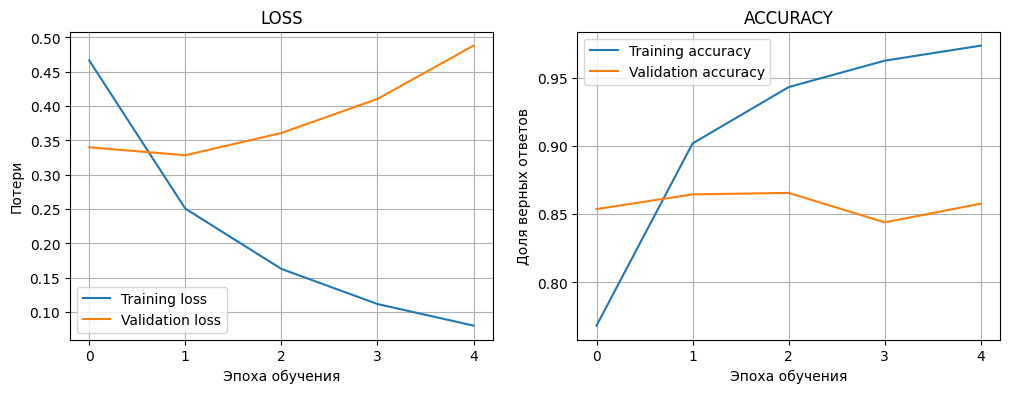

In [79]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('LOSS')
plt.xlabel('Эпоха обучения')
plt.ylabel('Потери')
plt.grid(True)
plt.legend()
plt.xticks(range(5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('ACCURACY')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.xticks(range(5))

plt.show()

# Проверка работы сети на тестовом наборе

In [83]:
model = keras.models.load_model(filepath='LSTM.keras')
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {scores[0]:.2f}, accuracy: {scores[1]:.2f}')

782/782 [==============================] - 51s 64ms/step - loss: 0.3341 - accuracy: 0.8631
Test loss: 0.33, accuracy: 0.86
